In [1]:
import numpy as np
import matplotlib.pyplot as plt

# David Silver's Easy21
## $Q$-Learning with $\epsilon$-Greedy Action Selection for Modified Blackjack

Assignment decription: https://www.davidsilver.uk/wp-content/uploads/2020/03/Easy21-Johannes.pdf

# MDP Description

State Space: $\{1, 2, 3, \dots, 10\} \times \{1, 2, 3, \dots, 21\}$

Action Space: $\{ "Hit", "Stick" \}$

Reward: 1 if win, -1 if lose, 0 otherwise

In [2]:
class Easy21Env:
    """
    Implementation of David Silver's Easy21 card game MDP
    """
    def __init__(self):
        self.player = None
        self.dealer = None
        self.is_terminal = None
    
    def gone_bust(self, total):
        return (total > 21) or (total < 1)
        
    def reset(self):
        self.player = np.random.randint(1, 11)
        self.dealer = np.random.randint(1, 11)
        self.is_terminal = False
        return self.player, self.dealer
    
    def step(self, action):
        reward = 0
        
        if action == "Hit":
            self.player += np.random.randint(1,11)*np.random.choice([-1,1], p=[1/3,2/3])
            if self.gone_bust(self.player):
                reward = -1
                self.is_terminal = True
                
        if action == "Stick":
            while self.dealer < 17 and not self.gone_bust(self.dealer):
                self.dealer += np.random.randint(1,11)*np.random.choice([-1,1], p=[1/3,2/3])
            if self.gone_bust(self.dealer):
                reward = 1
            else:
                reward = np.sign(self.player - self.dealer)
            self.is_terminal = True
                
        return self.player, self.dealer, reward, self.is_terminal

## $\epsilon$-Greedy Action Selection

In [3]:
def select_action(ϵ, values):
    # implementation of ϵ-greedy selection
    if(np.random.binomial(1, 1-ϵ)):
        arg_maxes = np.argwhere(values == np.amax(values))
        # break ties for max randomly (uniform)
        return "Hit" if int(arg_maxes[np.random.randint(0, len(arg_maxes))]) == 0 else "Stick"
    else:
        return np.random.choice(["Hit", "Stick"], p=[1/2, 1/2])

## Main learning loop

In [4]:
%%time
episodes = int(1e6)
N_0 = 100

# Initialize Q-function adn Environment
Q = np.zeros((21,10,2))
env = Easy21Env()

# Counters for plotting and updating ϵ and α
state_visits = np.zeros((21,10))
state_action_visits = np.zeros((21,10,2))
returns = []

print("I'm yearning for the learning!\n...\n")

# Main learning loop
for i in range(episodes):
    
    player, dealer = env.reset()
    cum_reward = 0
    done = False
    
    # Environment loop
    while not done:
        state_visits[player - 1, dealer - 1] += 1
        ϵ = N_0 / (N_0 + state_visits[player - 1, dealer - 1])
        
        # Select action according to ϵ-greedy
        action = select_action(ϵ, Q[player - 1, dealer - 1])
        
        # Obtain next state and reward
        player_next, dealer_next, reward, done = env.step(action)
        act = 0 if action == "Hit" else 1
        
        # Update Q function with Q-learning
        if done:
            TD_error = reward - Q[player - 1, dealer - 1, act]
        else:
            TD_error = reward + np.max(Q[player_next - 1, dealer_next - 1]) - Q[player - 1, dealer - 1, act]
        state_action_visits[player - 1, dealer - 1, act] += 1
        α = 1 / state_action_visits[player - 1, dealer - 1, act]
        Q[player - 1, dealer - 1, act] += α * TD_error
        
        player = player_next
        dealer = dealer_next
        cum_reward += reward
        
    returns.append(cum_reward)
print(f"Episode {episodes} / {episodes}\n\nI'm done learning! I am the blackjack master.\n")

I'm yearning for the learning!
...

Episode 1000000 / 1000000

I'm done learning! I am the blackjack master.

CPU times: user 49.9 s, sys: 361 ms, total: 50.2 s
Wall time: 50.1 s


## Plot Moving Average of Returns

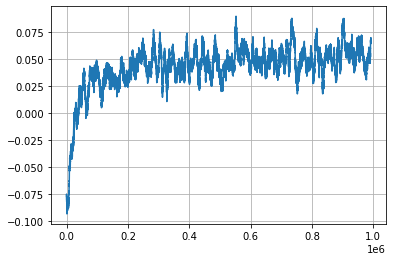

In [5]:
def moving_average(a, n) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

plt.plot(moving_average(returns, 8000))
plt.grid()

## Plot Learned Policy $\pi(s) = argmax_{a}Q(s,a)$

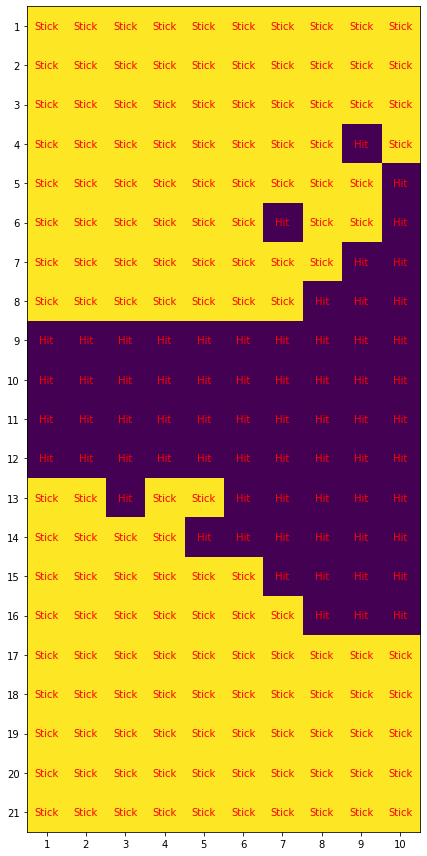

In [6]:
# Plot opltmal policy
arg_maxes = np.argmax(Q, axis=2)
player_vals = np.arange(1,22)
dealer_vals = np.arange(1,11)

fig, ax = plt.subplots(figsize=(22,12))
im = ax.imshow(arg_maxes)

ax.set_xticks(np.arange(len(dealer_vals)))
ax.set_yticks(np.arange(len(player_vals)))
ax.set_xticklabels(dealer_vals)
ax.set_yticklabels(player_vals)

for i in range(len(player_vals)):
    for j in range(len(dealer_vals)):
        action = "Hit" if arg_maxes[i,j] == 0 else "Stick"
        text = ax.text(j,i, action, ha = "center", va = "center", color = "r")

fig.tight_layout()
plt.show()

## Plot Learned Value function $V(s) = \max_a Q(s,a)$

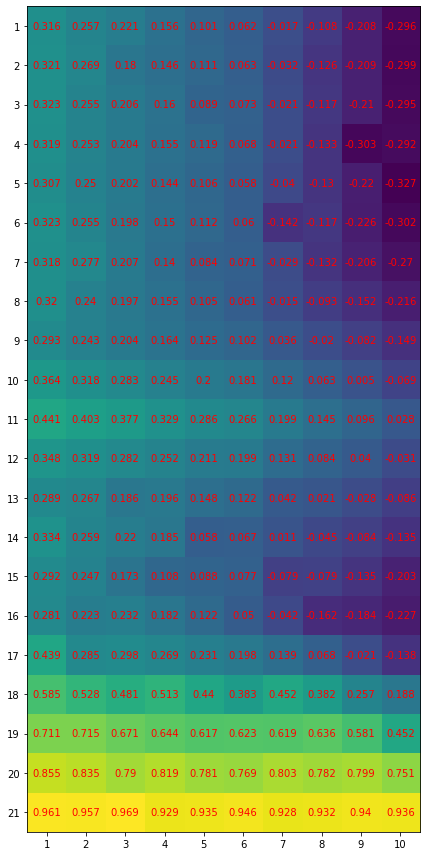

In [7]:
# Plot optimal value function
V = np.max(Q, axis=2)
player_vals = np.arange(1,22)
dealer_vals = np.arange(1,11)

fig, ax = plt.subplots(figsize=(60,12))
im = ax.imshow(V)

ax.set_xticks(np.arange(len(dealer_vals)))
ax.set_yticks(np.arange(len(player_vals)))
ax.set_xticklabels(dealer_vals)
ax.set_yticklabels(player_vals)

for i in range(len(player_vals)):
    for j in range(len(dealer_vals)):
        text = ax.text(j,i, round(V[i,j],3), ha = "center", va = "center", color = "r")

fig.tight_layout()
plt.show()